## 4 Running statmorph

Here we show an example statmorph run for one of the augmented galaxies. This is pretty straightforward!

We use `statmorph_lsst`, which includes some edits to the original code. All of the changes will be documented on the GitHub page. As of now, the major changes are:

* New `isophote_asymmtry` is introduced (optional, needs passing the `asymmetry_isophotes` argument)
* New `substructure` is intrpoduced
* Shape asymmetry, Gini, and MID segmaps are now generated on an image where enclosed masked pixels are interpolated over
    * This deals with the issue where long masked streaks (e.g., bad columns, satellites) break up the source segmap, causing the source to be deblended into two sources
* We use RMS asymmetry for the asymmetry centre calculation, since it is more robust to noise by default, and is more heavily flux-weighted, which corresponds more to the image centroid
* In the original statmorph many functions convolve the image where mask is zeroed. This means the masked zeroes effectively "bleed" into real pixels. Instead set masked pixels to `nan` and use Astropy's convolution, which deals with `nan` values
* Intensity now sets a minimum threshold for a peak, 5% of the maximum flux in the image. We also limit the number of detected peaks to 100 to speed up the calculation. This does not matter in the end since only the top two peaks are used in the MID calculation.
 
#### Imports

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import json
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from astropy.io import fits
from statmorph_lsst import statmorph_lsst
from statmorph_lsst.utils import rle_to_segmap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the image

Choose one galaxy to run statmorph for as an example

In [49]:
catalog = pd.read_csv('../data/catalogs/augments.csv')
segmap_errors = pd.read_csv('../data/catalogs/segmap_errors.csv')

tmp = pd.merge(catalog, segmap_errors, left_on=['galaxy','pxscale_pc','sblim'], right_on=['galaxy','pxscale_pc','sblim'])
catalog = catalog[~catalog.index.isin(tmp.index)]
row = catalog.sample(n=1).iloc[0]
row

galaxy            gmp3098
pxscale_pc         46.984
pxscale_arcsec        0.1
sblim                24.5
Name: 52918, dtype: object

Load in the data and the segmap

In [50]:
# Load the cutout fits file
file = fits.open(f'../data/augments/{row.galaxy}/px{int(row.pxscale_pc)}_sb{row.sblim:0.2f}.fits')

# Relevant arrays
img = file['SCI'].data
err = file['ERR'].data
mask = file['MASK'].data > 0
h = file['SCI'].header
psf = file['PSF'].data

# Segmap and foreground source mask
with open(f'../data/segmaps/{row.galaxy}/px{int(row.pxscale_pc)}_sb{row.sblim:0.2f}.json', 'r') as f:
    segmap_dict = json.load(f)
    segmap = rle_to_segmap(segmap_dict['segmap']) 
    segmask = rle_to_segmap(segmap_dict['segmask']) 
    if segmask is not None:
        segmask = segmask > 0
    else:
        segmask = np.zeros_like(segmap).astype(bool)

Plot the image and the segmap

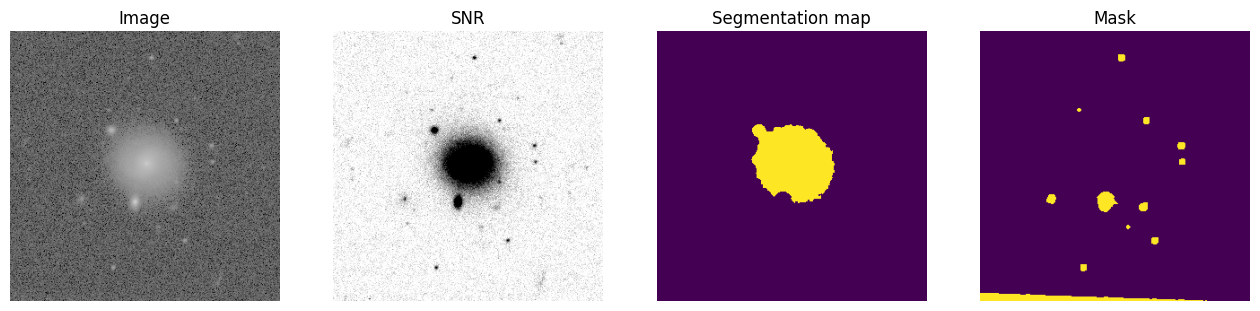

In [51]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

axs[0].imshow(-2.5*np.log10(np.abs(img)/h['pxscale']**2)+h['zp'], vmin=17, vmax=30, cmap='gray_r')
axs[1].imshow(img/err, vmin=0, vmax=10, cmap='gray_r')
axs[2].imshow(segmap)
axs[3].imshow(segmask | mask)

labels = ['Image', 'SNR', 'Segmentation map', 'Mask']
for ax, l in zip(axs, labels):
    ax.set_title(l)
    ax.axis('off')

## Run statmorph

To calculate isophotal asymmetry we need to define the asymmetry isophotes. Let's define them as different surface brightness levels (which is what I'd recomment, since these map to $L_\odot/$pc$^2$).

In [52]:
sb_isophotes = np.arange(17, 25, 0.5)
img_isophotes = np.power(10, (h['zp']-sb_isophotes)/2.5) * h['pxscale']**2

Run statmorph:

In [53]:
morph = statmorph_lsst.source_morphology(img, segmap=segmap, mask=segmask|mask, weightmap=err, psf=psf, asymmetry_isophotes=img_isophotes, skybox_size=int(0.15*img.shape[0]))[0]

Plot the diagnostic figures:

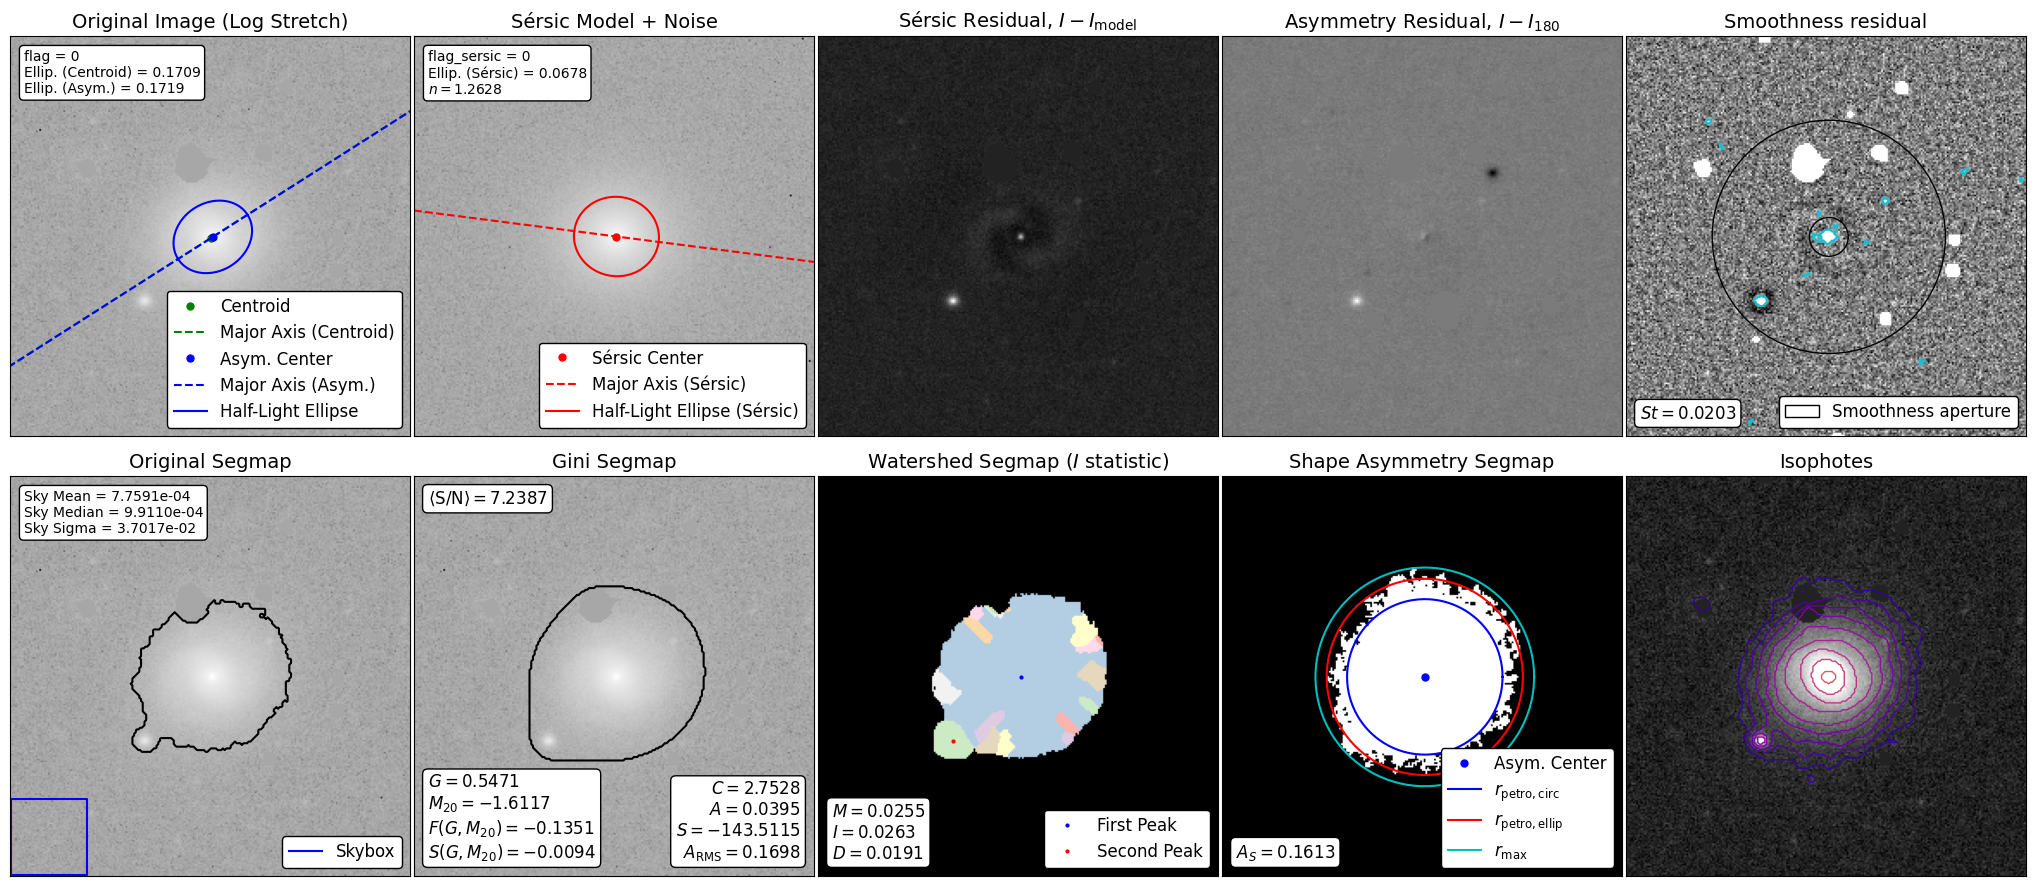

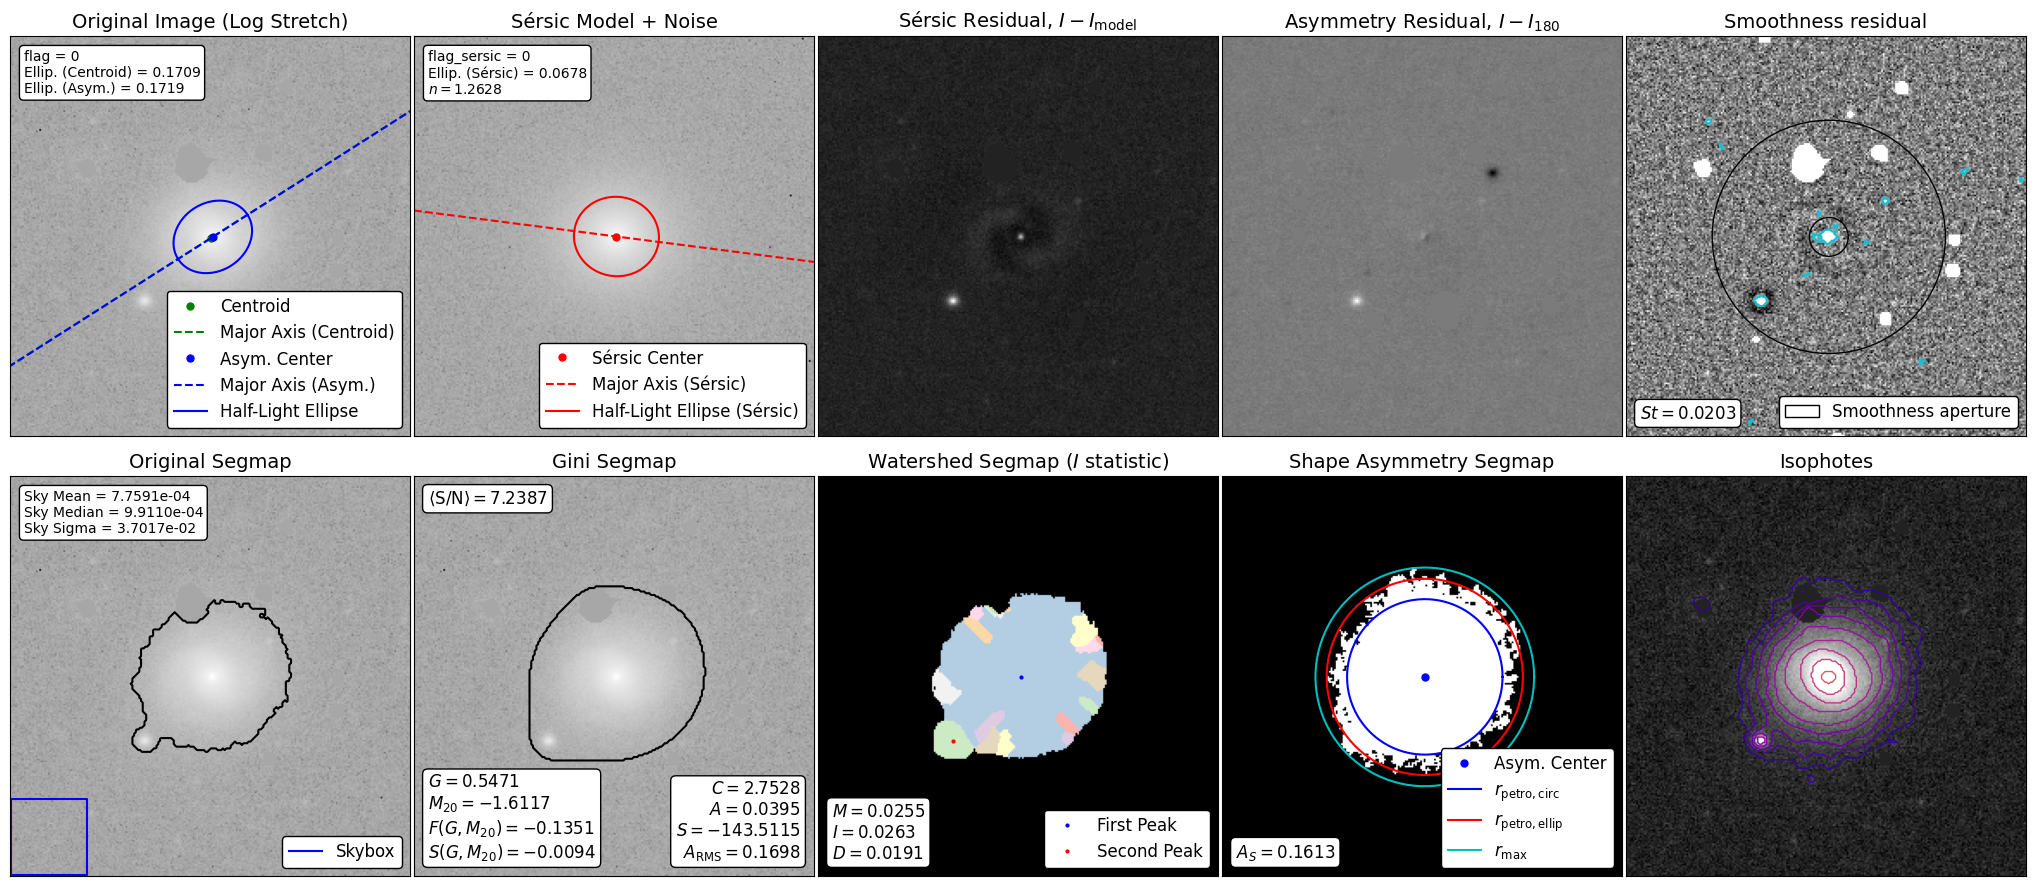

In [54]:
from statmorph_lsst.utils import image_diagnostics
image_diagnostics.make_figure(morph)